In [1]:
import pandas as pd
import seaborn as sns
import pymc as pm

sns.set_theme()

In [2]:
data = pd.read_csv("datasets/hurricanes.csv", sep="\t")
data.head()
data["year"] = data["Year"] - 1851

In [3]:
data["Hurricanes"].mean()

5.526315789473684

In [4]:
def generate_samples(m:pm.model.Model, target_accept=0.8, max_treedepth=10) -> tuple:
    with m:
        trace = pm.sample(target_accept=target_accept, max_treedepth=max_treedepth)
        posterior = pm.sample_posterior_predictive(trace)

    return trace, posterior

In [5]:
def plot_prior_predictive(prior, data=data):
    priors = prior["prior_predictive"].sel(chain=[0]).to_dataframe().reset_index()
    priors["obs_dim_0"] = priors["obs_dim_0"] + data["Year"].min()

    ax = sns.scatterplot(priors, x="obs_dim_0", y="obs", alpha=0.25, s=5)
    ax.scatter(x=data["Year"], y=data["Hurricanes"], s=10)

## Distribution of Hurricanes by year

<AxesSubplot: xlabel='Hurricanes', ylabel='Count'>

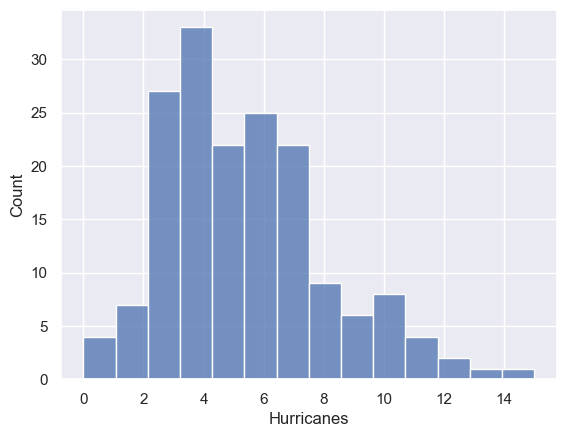

In [8]:
sns.histplot(data, x="Hurricanes")

## Scatter Plot of Hurricanes vs. Year

<AxesSubplot: xlabel='Year', ylabel='Hurricanes'>

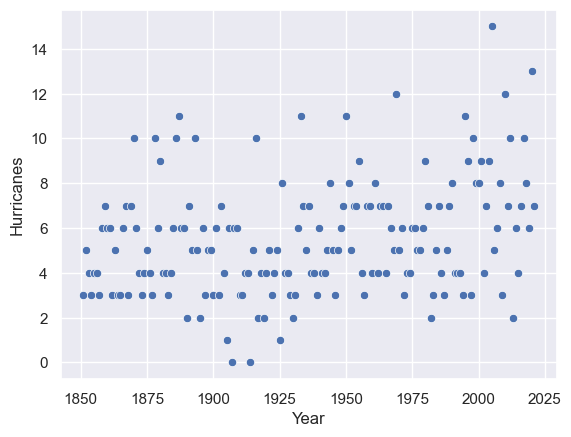

In [9]:
sns.scatterplot(data, x="Year", y="Hurricanes")

## A Linear Regression Across the Dataset

In [10]:
with pm.Model() as m0:
    year = pm.Data("year", data["year"])
    hurricanes = pm.Data("hurricanes", data["Hurricanes"])
    
    alpha = pm.Normal("alpha", mu=0, sigma=5)
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.Exponential("sigma", 1/5)

    obs = pm.Normal("obs", mu=alpha + beta*year, sigma=sigma, observed=hurricanes)

/Users/btb/Projects/bayesian_notebooks/.venv/lib/python3.8/site-packages/pymc/data.py:671: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


In [11]:
trace_m0, posterior_m0 = generate_samples(m0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


array([[<AxesSubplot: title={'center': 'alpha'}>,
        <AxesSubplot: title={'center': 'alpha'}>],
       [<AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'beta'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>]], dtype=object)

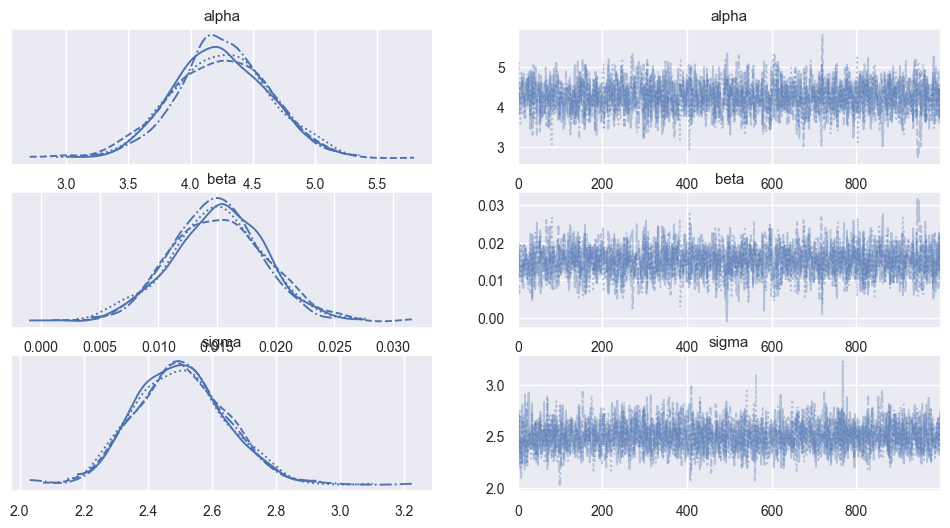

In [12]:
pm.plot_trace(trace_m0)

<AxesSubplot: xlabel='Year', ylabel='Hurricanes'>

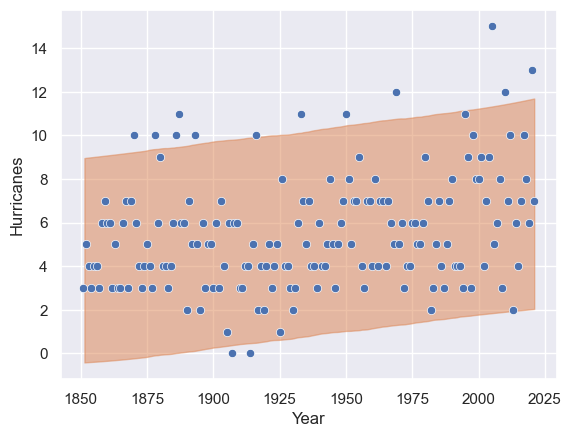

In [85]:
pm.plot_hdi(x=data["Year"], y=posterior_m0["posterior_predictive"].to_array().squeeze())
sns.scatterplot(data, x="Year", y="Hurricanes")

In [95]:
with pm.Model() as m0b:
    year = pm.Data("year", data["year"])
    hurricanes = pm.Data("hurricanes", data["Hurricanes"])
    
    alpha = pm.Normal("alpha", mu=0, sigma=5)
    beta = pm.Normal("beta", mu=0, sigma=1)

    lam = pm.math.exp(alpha + beta*year)

    obs = pm.Poisson("obs", mu=lam, observed=hurricanes)

/Users/btb/Projects/bayesian_notebooks/.venv/lib/python3.8/site-packages/pymc/data.py:671: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


In [96]:
trace_m0b, posterior_m0b = generate_samples(m0b)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


array([[<AxesSubplot: title={'center': 'alpha'}>,
        <AxesSubplot: title={'center': 'alpha'}>],
       [<AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'beta'}>]], dtype=object)

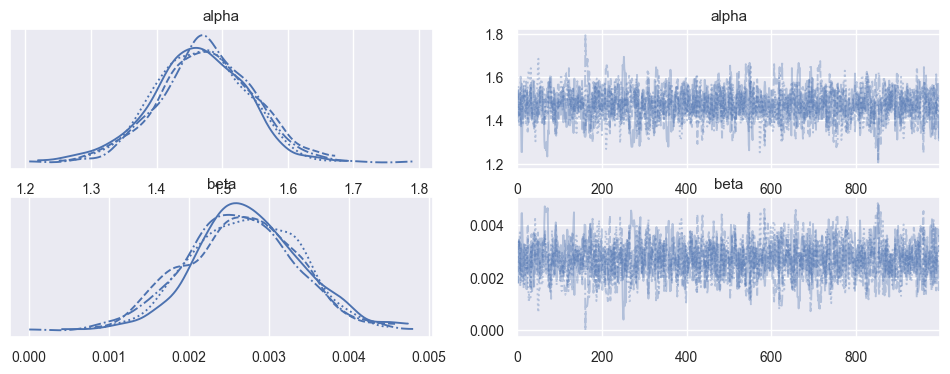

In [97]:
pm.plot_trace(trace_m0b)

<AxesSubplot: xlabel='Year', ylabel='Hurricanes'>

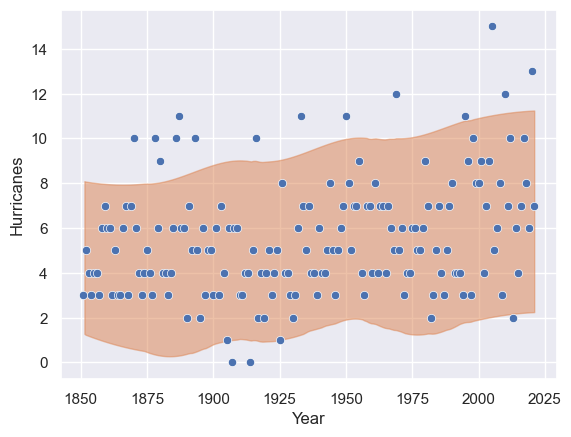

In [98]:
pm.plot_hdi(x=data["Year"], y=posterior_m0b["posterior_predictive"].to_array().squeeze())
sns.scatterplot(data, x="Year", y="Hurricanes")


## Model 1 - Poisson Distributed with prior Exponential(1/5)

In [37]:
with pm.Model() as m1:
    h = pm.Data("h", data["Hurricanes"])

    theta = pm.Exponential("theta", 1/5)
    obs = pm.Poisson("obs", mu=theta, observed=h)
    
with m1:
    priors_m1 = pm.sample_prior_predictive(20)

/Users/btb/Projects/bayesian_notebooks/.venv/lib/python3.8/site-packages/pymc/data.py:671: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


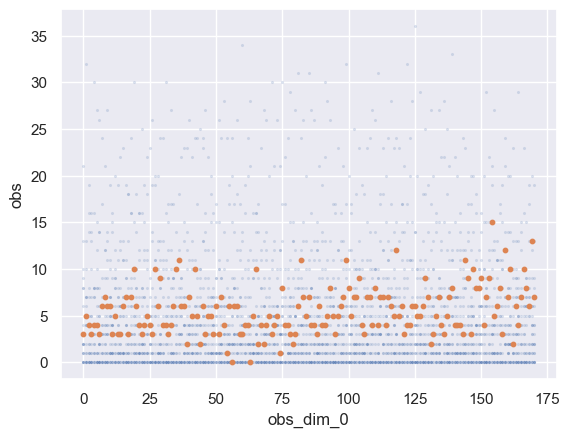

In [38]:
priors = priors_m1["prior_predictive"].sel(chain=[0]).to_dataframe().reset_index()
priors["obs_dim_0"] = priors["obs_dim_0"] + data["year"].min()

ax = sns.scatterplot(priors, x="obs_dim_0", y="obs", alpha=0.2, s=5)
ax.scatter(x=data["year"], y=data["Hurricanes"], s=10)

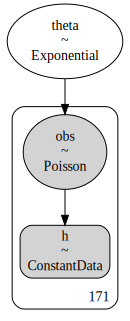

In [39]:
pm.model_to_graphviz(m1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8792, but should be close to 0.8. Try to increase the number of tuning steps.


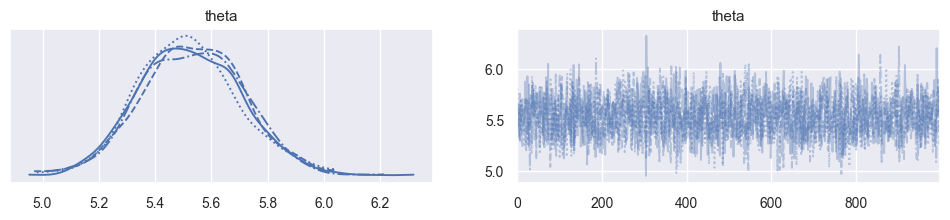

In [40]:
with m1:
    trace_m1 = pm.sample()
    pm.plot_trace(trace_m1)
    posterior_m1 = pm.sample_posterior_predictive(trace_m1)

<AxesSubplot: xlabel='Year', ylabel='Hurricanes'>

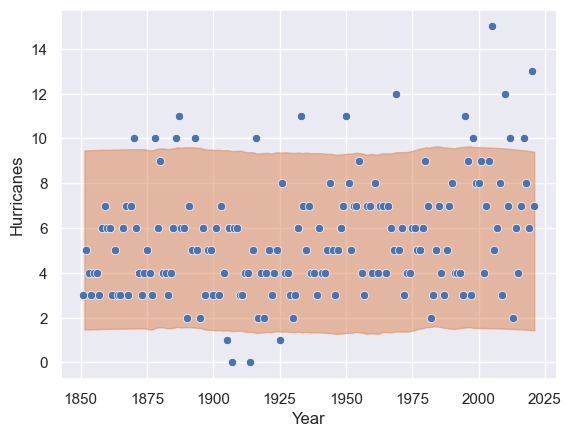

In [41]:
pm.plot_hdi(x=data["Year"], y=posterior_m1["posterior_predictive"].to_array().squeeze())
sns.scatterplot(data, x="Year", y="Hurricanes")

## Model 1b - Poisson distributed with Gamma(2,1/2) Prior

In [42]:
with pm.Model() as m1b:
    h = pm.Data("h", data["Hurricanes"])

    theta = pm.Gamma("theta", alpha=2, beta=1/2)
    obs = pm.Poisson("obs", mu=theta, observed=h)
    
    priors_m1b = pm.sample_prior_predictive(20)

/Users/btb/Projects/bayesian_notebooks/.venv/lib/python3.8/site-packages/pymc/data.py:671: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


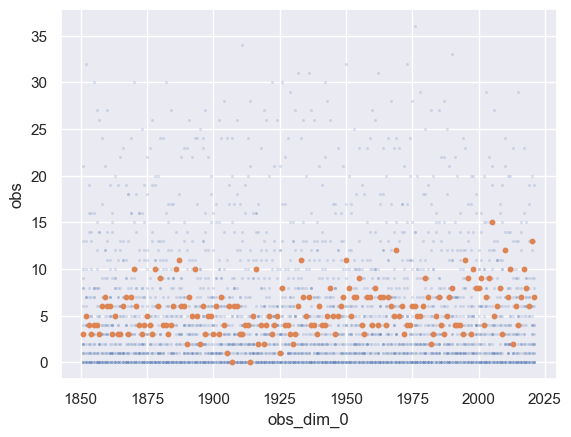

In [43]:
priors = priors_m1["prior_predictive"].sel(chain=[0]).to_dataframe().reset_index()
priors["obs_dim_0"] = priors["obs_dim_0"] + data["Year"].min()

ax = sns.scatterplot(priors, x="obs_dim_0", y="obs", alpha=0.2, s=5)
ax.scatter(x=data["Year"], y=data["Hurricanes"], s=10)

In [44]:
with m1b:
    trace_m1b = pm.sample()
    posterior_m1b = pm.sample_posterior_predictive(trace_m1b)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


<AxesSubplot: xlabel='Year', ylabel='Hurricanes'>

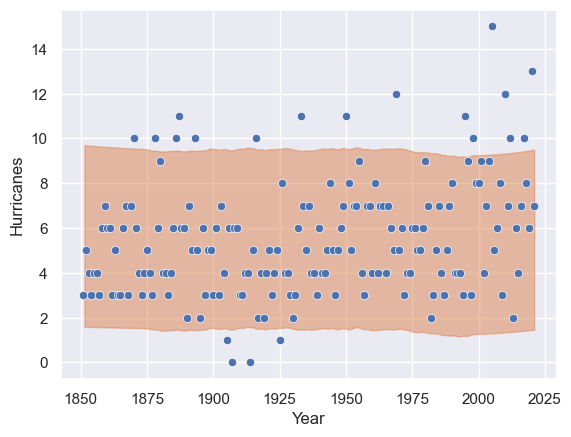

In [45]:
pm.plot_hdi(x=data["Year"], y=posterior_m1b["posterior_predictive"].to_array().squeeze())
sns.scatterplot(data, x="Year", y="Hurricanes")

## Model 2 - Negative Binomial Distributed w/ Gamma Priors on alpha, beta

In [46]:
with pm.Model() as m2:
    h = pm.Data("h", data["Hurricanes"])

    alpha = pm.Gamma("alpha", alpha=2, beta=1)    # A shape parameter that captures variance
    mu = pm.Gamma("mu", alpha=6, beta=1)
    obs = pm.NegativeBinomial("obs", alpha=alpha, mu=mu, observed=h)
    
    priors_m2 = pm.sample_prior_predictive(20)

/Users/btb/Projects/bayesian_notebooks/.venv/lib/python3.8/site-packages/pymc/data.py:671: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


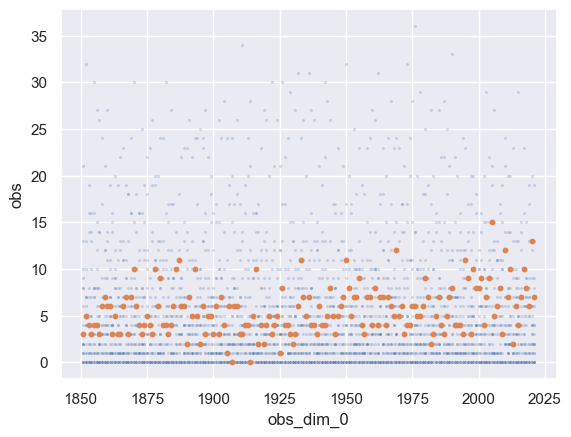

In [47]:
priors = priors_m1["prior_predictive"].sel(chain=[0]).to_dataframe().reset_index()
priors["obs_dim_0"] = priors["obs_dim_0"] + data["Year"].min()

ax = sns.scatterplot(priors, x="obs_dim_0", y="obs", alpha=0.25, s=5)
ax.scatter(x=data["Year"], y=data["Hurricanes"], s=10)

In [48]:
trace_m2, posterior_m2 = generate_samples(m2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


<AxesSubplot: xlabel='Year', ylabel='Hurricanes'>

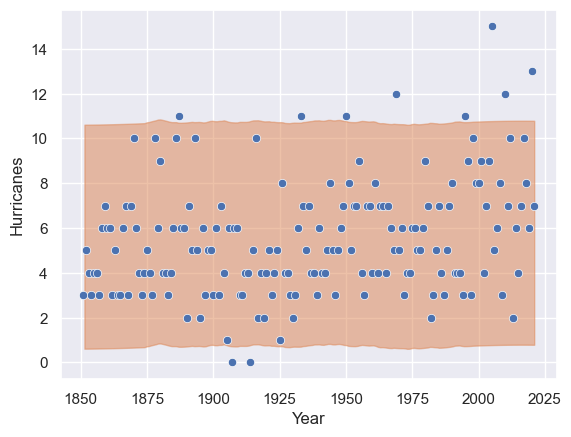

In [49]:
pm.plot_hdi(x=data["Year"], y=posterior_m2["posterior_predictive"].to_array().squeeze())
sns.scatterplot(data, x="Year", y="Hurricanes")

In [99]:
with pm.Model() as m3:
    year = pm.Data("year", data["Year"])
    hurricanes = pm.Data("hurricanes", data["Hurricanes"])
    
    u = pm.Uniform("u", year.min(), year.max())

    lam = pm.Exponential("lam", 1/5, shape=2)
    lam_ = pm.math.switch(year > u, lam[0], lam[1])

    obs = pm.Poisson("obs", mu=lam_, observed=hurricanes)

    priors_m3 = pm.sample_prior_predictive(20)


/Users/btb/Projects/bayesian_notebooks/.venv/lib/python3.8/site-packages/pymc/data.py:671: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


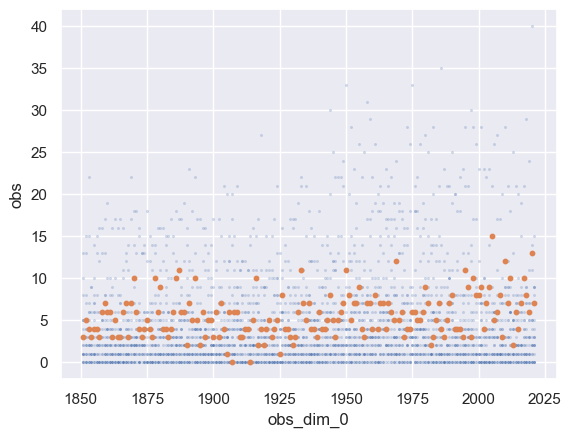

In [100]:
plot_prior_predictive(priors_m3)

In [101]:
trace_m3, posterior_m3 = generate_samples(m3, target_accept=0.9, max_treedepth=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u, lam]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 198 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8391, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


array([[<AxesSubplot: title={'center': 'u'}>,
        <AxesSubplot: title={'center': 'u'}>],
       [<AxesSubplot: title={'center': 'lam'}>,
        <AxesSubplot: title={'center': 'lam'}>]], dtype=object)

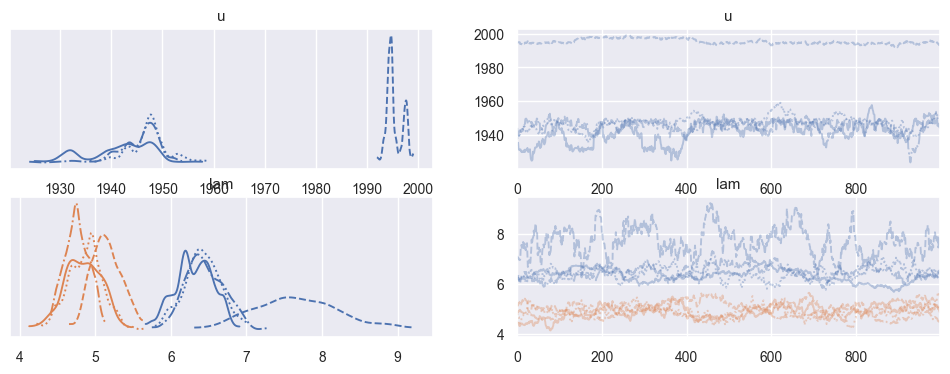

In [102]:
pm.plot_trace(trace_m3)

<AxesSubplot: xlabel='Year', ylabel='Hurricanes'>

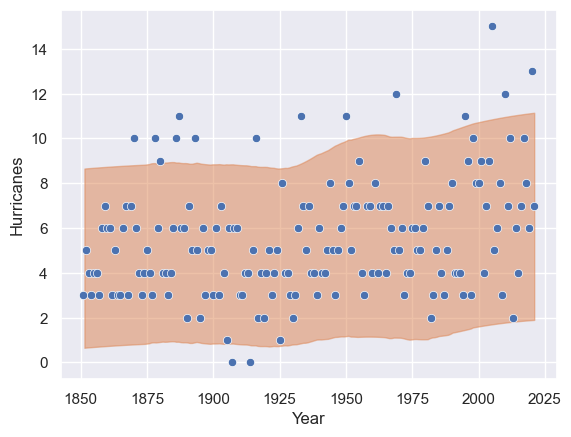

In [104]:
pm.plot_hdi(x=data["Year"], y=posterior_m3["posterior_predictive"].to_array().squeeze())
sns.scatterplot(data, x="Year", y="Hurricanes")

## Model 3 - Gaussian Process

In [50]:
with pm.Model() as m3:
    year = pm.Data("year", data["Year"])
    hurricanes = pm.Data("hurricanes", data["Hurricanes"])

    # informative lengthscale prior
    l = pm.Gamma("l", alpha=2, beta=1)
    # informative, positive normal prior on the period
    eta = pm.HalfNormal("eta", sigma=5)
    cov = eta ** 2 * pm.gp.cov.ExpQuad(1, l)

    gp = pm.gp.Latent(cov_func=cov)

    # make gp prior
    f = gp.prior("f", X=year[:,None])

    # logit link and Bernoulli likelihood
    mu = pm.Deterministic("p", pm.math.exp(f))
    y_ = pm.Poisson("y", mu=mu, observed=hurricanes)

    # trace = pm.sample()

/Users/btb/Projects/bayesian_notebooks/.venv/lib/python3.8/site-packages/pymc/data.py:671: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


In [54]:
pm.model_to_graphviz(m3)

ImportError: This function requires the python library graphviz, along with binaries. The easiest way to install all of this is by running

	conda install -c conda-forge python-graphviz